# **Project 3: Hamburger/Hotdog**


## **Import the necessary libraries**

In [1]:
from PIL import Image
import pandas as pd
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# TensorFlow modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


# scikit-learn modules
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Library for randomly selecting data points
import random

from Utils import plot_training_history, evaluate_model, plot_confusion_matrix, calculate_additional_metrics, load_and_summarize_model, visualize_feature_maps, plot_cam, plot_precision_recall_curve, plot_roc_curve, plot_conv_filters, plot_misclassified_examples

## **Load and Prepare the Dataset**

- Load and standardize the dataset
- Extract and encode lables.
- Split the data into the train and the test dataset.

In [2]:
# Function to Load Images and Labels
# This function walks through the directory structure, loads the images, converts them into a consistent format,
# resizes them as needed and extracts labels from the directory names:

def load_images_from_folder(folder, count, img_size=(256, 256)):
    images = []
    for idx, filename in enumerate(os.listdir(folder)):
        if idx >= count:  # Only load up to 'count' images
            break
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert to RGB
                img = img.resize(img_size)  # Resize the image
                images.append(np.array(img))
    return np.array(images)

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# Load Images and Create Labels
#hotdog_folder = '/content/hamburger_images'
#hamburger_folder = '/content/hotdog_images'

hotdog_folder = "/content/drive/MyDrive/IMAGES/HOTDOG_SOURCE"
hamburger_folder = "/content/drive/MyDrive/IMAGES/HAMBURGER_SOURCE"

# Load images
hotdog_images = load_images_from_folder(hotdog_folder,1000)
hamburger_images = load_images_from_folder(hamburger_folder,1000)

# Create labels (zeros and ones for the hotdog and notdog images)
hotdog_labels = np.ones(len(hotdog_images))
hamburger_labels = np.zeros(len(hamburger_images))

# Combine images and labels
X = np.concatenate((hotdog_images, hamburger_images), axis=0)
y = np.concatenate((hotdog_labels, hamburger_labels), axis=0)

In [5]:
print(len(hamburger_images))
print(len(hotdog_images))

1000
1000


In [6]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

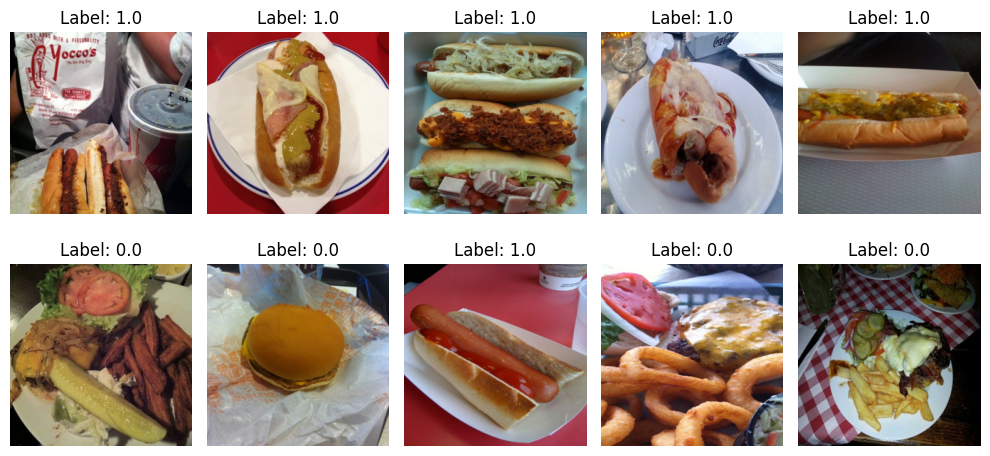

In [7]:
# Visualize the first 10 images in the dataset and printing their classification labels

def plot_images(images, labels, num_images=10):
    # Set up the figure size in inches
    plt.figure(figsize=(10, 5))

    for i in range(num_images):
        # Create a subplot for each image
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')  # Turn off axis numbering

    plt.tight_layout()
    plt.show()

plot_images(X_train, y_train)


## **Data preparation**
- Normalize the train and the test dataset by dividing by 255.

In [8]:
# Normalizing the image pixel inputs
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
# Displaying the first normalized training image
print('Test Dataset:', X_test.shape, y_test.shape)
print('Training Dataset:', X_train.shape, y_train.shape)

Test Dataset: (400, 256, 256, 3) (400,)
Training Dataset: (1600, 256, 256, 3) (1600,)


In [10]:
# Displaying the first normalized testing image and its pixel values
print("Shape of the first normalized testing image:", X_test[0].shape)
print("Pixel values of the first normalized testing image:")
print(X_test[0])

Shape of the first normalized testing image: (256, 256, 3)
Pixel values of the first normalized testing image:
[[[0.6        0.11764706 0.26666667]
  [0.58431373 0.10588235 0.25098039]
  [0.58039216 0.10980392 0.25882353]
  ...
  [0.6        0.81176471 0.98431373]
  [0.6        0.82352941 0.99215686]
  [0.6        0.83137255 0.99607843]]

 [[0.49019608 0.07058824 0.21960784]
  [0.47843137 0.0627451  0.20784314]
  [0.46666667 0.0627451  0.20784314]
  ...
  [0.60392157 0.81568627 0.98823529]
  [0.60392157 0.82745098 0.99607843]
  [0.60392157 0.83137255 1.        ]]

 [[0.35686275 0.04313725 0.19215686]
  [0.35294118 0.04705882 0.19215686]
  [0.34901961 0.05098039 0.19215686]
  ...
  [0.60784314 0.81960784 0.99215686]
  [0.60784314 0.83529412 0.99607843]
  [0.60784314 0.83921569 0.99607843]]

 ...

 [[0.04705882 0.04705882 0.08627451]
  [0.04313725 0.04313725 0.09019608]
  [0.04313725 0.04313725 0.09019608]
  ...
  [0.07843137 0.03921569 0.07058824]
  [0.05882353 0.05490196 0.06666667]
  

## **Analysis**

In [11]:
### Saved Models
model_paths = [
    Path("/content/drive/MyDrive/IMAGES/CNN_Model_1.keras"),
    Path("/content/drive/MyDrive/IMAGES/CNN_Model_2.keras"),
    Path("/content/drive/MyDrive/IMAGES/CNN_Model_3.keras"),
    Path("/content/drive/MyDrive/IMAGES/CNN_Model_4.keras"),
    Path("/content/drive/MyDrive/IMAGES/CNN_Model_5.keras")
]

---
### **CNN Model - Iteration #1**

In [12]:
#Load and Summarize Model
model_1 = load_and_summarize_model(model_paths[0])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 64)                33032256  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33033217 (126.01 MB)
Trainable params: 33033217 (126.01 MB)
Non-trainable params: 0 (0.00 Byte)
____________

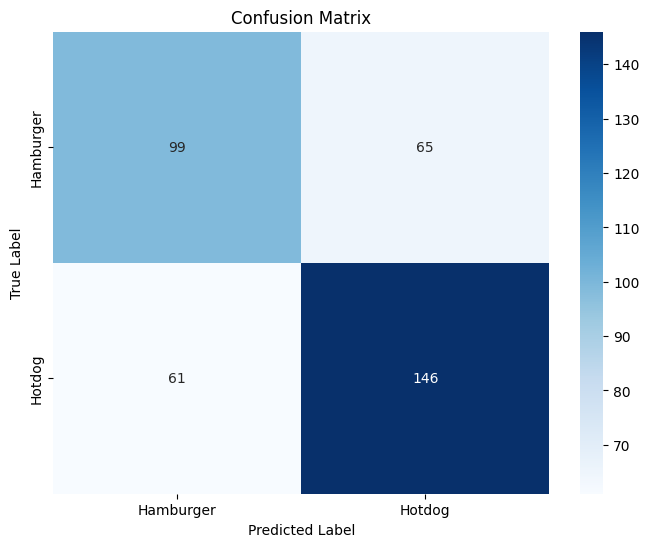

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

1/1 [==============================] - 2s 2s/step
Layer 0 activation shape: (1, 254, 254, 32)
Layer 1 activation shape: (1, 127, 127, 32)
Layer 2 activation shape: (1, 516128)
Layer 3 activation shape: (1, 64)


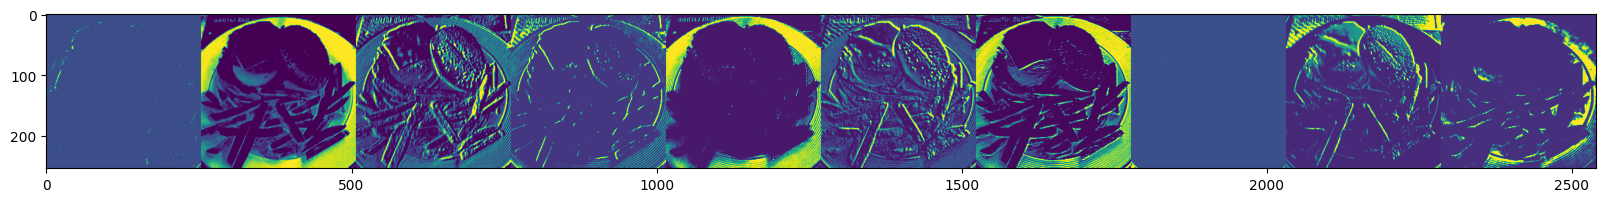

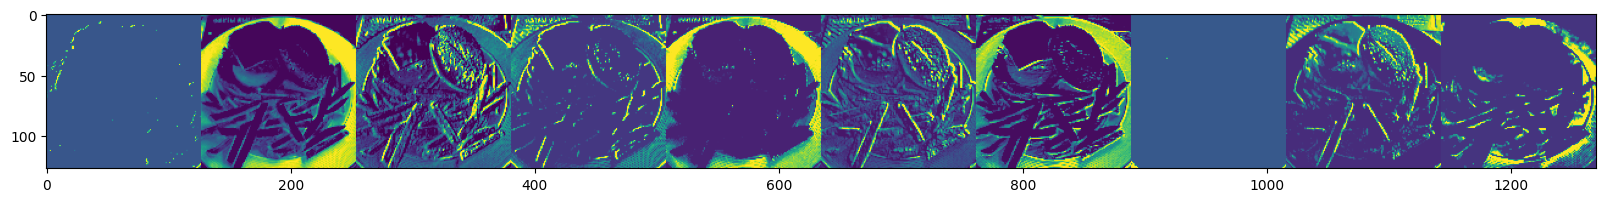

Skipping layer with shape (1, 516128) (not 4D)
Skipping layer with shape (1, 64) (not 4D)


In [13]:
# Evaluating on the Test dataset

from tensorflow.keras import models as keras_models

X_input = X_test[:1]  # Reduce the number of channels to 3

# Visualize feature maps (with reduced number of layers and features to visualize to avoid memory issues)
visualize_feature_maps(model_1, X_input, max_layers=4, max_features=10)

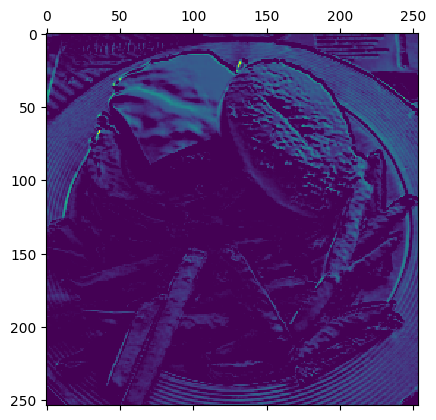

In [16]:
# Class Activation Map
img_array = X_test[:1]
class_idx = np.argmax(y_test[0])
plot_cam(model_1, img_array, class_idx, 'conv2d')  # Specify the convulusional layer name

In [ ]:
# Make Predictions
y_pred = model_1.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

12/12 [==============================] - 0s 12ms/step


13/13 [==============================] - 0s 12ms/step


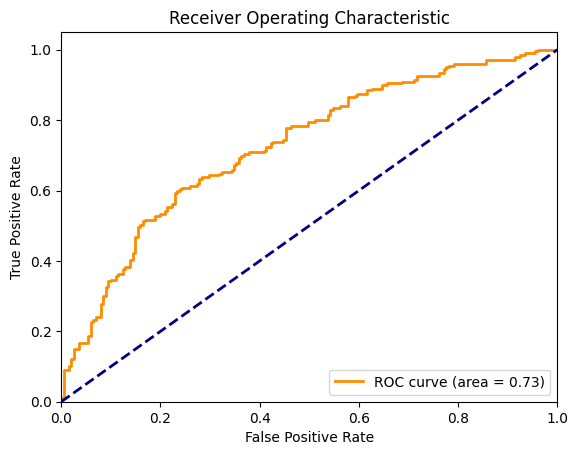

In [16]:
# ROC Curve and AUC
y_pred_probs = model_1.predict(X_test)
plot_roc_curve(y_test, y_pred_probs)

13/13 [==============================] - 0s 12ms/step


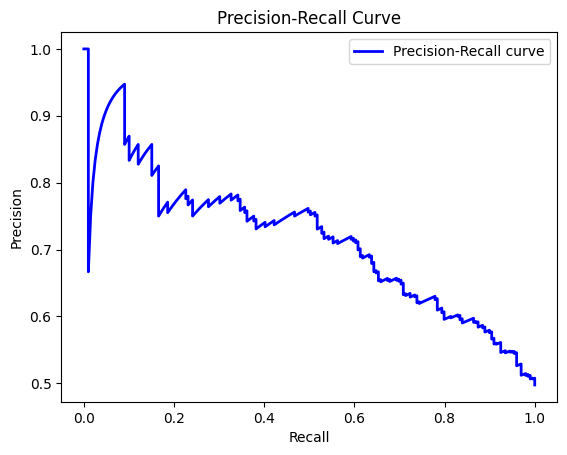

In [14]:
# Precision-Recall Curve
y_pred_probs = model_1.predict(X_test)
plot_precision_recall_curve(y_test, y_pred_probs)

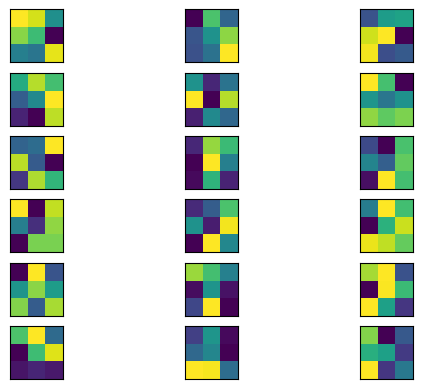

In [15]:
conv_layer = model_1.get_layer('conv2d')
plot_conv_filters(conv_layer, 'conv2d')

### **CNN Model - Iteration #2**

### Augmentation

In [ ]:
# Apply augmentation to the whole training dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation (degrees)
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1, # Random vertical shift
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    vertical_flip=False,    # No vertical flip for face images
    fill_mode='nearest'     # Fill mode for handling newly created pixels
)

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images.
for i in range(len(X_train)):
    # Select the image
    img = X_train[i]
    # Select the label from the training data
    label = y_train[i]

    # Ensure that the input data has the correct shape (Add batch dimension)
    img = np.expand_dims(img, axis=0)

    # Create the iterator
    it = datagen.flow(img, batch_size=1)

    # Add 5 augmented images for every original image
    for j in range(5):
        # Append a new image to the X list
        X_train_aug.append(next(it)[0])  # Correctly use next() with the iterator
        # Append the label for the original image to the y list
        y_train_aug.append(label)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))


7400
7400


In [ ]:
# Convert lists to numpy arrays
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

# Ensure X_train_aug is a 4D array and y_train_aug is a 1D array
print("X_train_aug shape:", X_train_aug.shape)
print("y_train_aug shape:", y_train_aug.shape)


X_train_aug shape: (7400, 256, 256, 3)
y_train_aug shape: (7400,)


In [ ]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define CNN model_2
model_2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
batch_size = 32
epochs = 10
history_2 = model_2.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/10
232/232 [==============================] - 9s 36ms/step - loss: 0.7775 - accuracy: 0.6393 - val_loss: 0.6125 - val_accuracy: 0.6550
Epoch 2/10
232/232 [==============================] - 8s 34ms/step - loss: 0.4885 - accuracy: 0.7676 - val_loss: 0.5924 - val_accuracy: 0.6900
Epoch 3/10
232/232 [==============================] - 8s 34ms/step - loss: 0.2856 - accuracy: 0.8861 - val_loss: 0.7779 - val_accuracy: 0.7035
Epoch 4/10
232/232 [==============================] - 8s 34ms/step - loss: 0.1232 - accuracy: 0.9616 - val_loss: 0.8739 - val_accuracy: 0.6604
Epoch 5/10
232/232 [==============================] - 8s 34ms/step - loss: 0.0458 - accuracy: 0.9908 - val_loss: 1.2141 - val_accuracy: 0.6792
Epoch 6/10
232/232 [==============================] - 8s 34ms/step - loss: 0.0273 - accuracy: 0.9954 - val_loss: 1.2674 - val_accuracy: 0.6981
Epoch 7/10
232/232 [==============================] - 8s 34ms/step - loss: 0.0136 - accuracy: 0.9981 - val_loss: 1.4506 - val_accuracy: 0.6523

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_2, X_test, y_test)

12/12 [==============================] - 0s 14ms/step - loss: 2.0142 - accuracy: 0.7008
Test Loss: 2.014226198196411
Test Accuracy: 0.7008086442947388


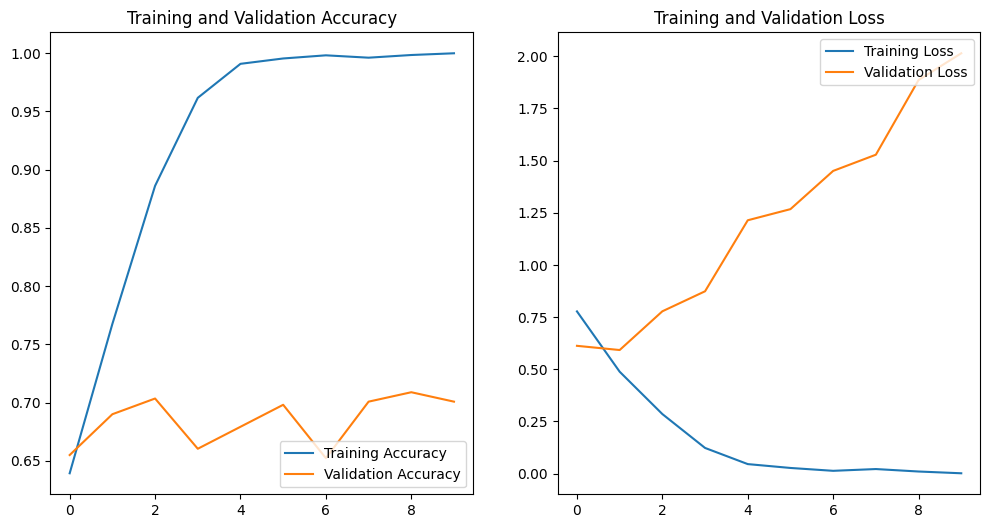

In [ ]:
# Accuracy and Loss Plots
plot_training_history(history_2)

In [ ]:
# Make Predictions
y_pred = model_2.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

12/12 [==============================] - 0s 12ms/step


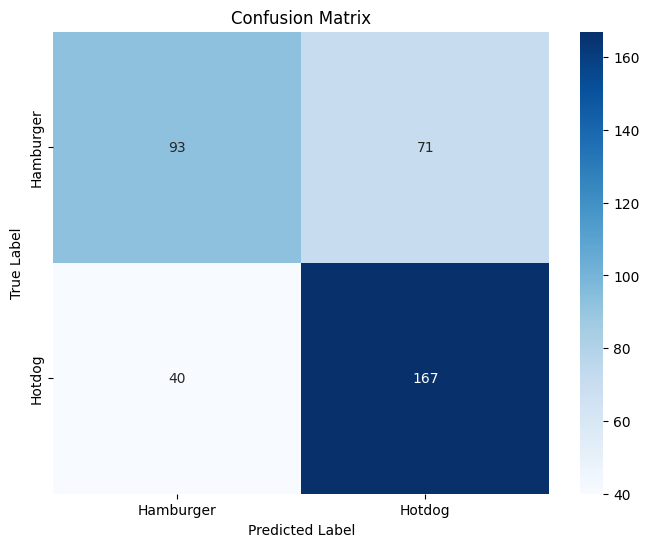

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

### **CNN Model - Iteration #3**

### Dropout
Dropout is a technique where randomly selected neurons are ignored during training, reducing the chance of overfitting.

In [ ]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.layers import Dropout

# Define CNN model_3 with Dropout

model_3 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout layer after pooling
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),   # Dropout layer after first dense layer
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
batch_size = 32
epochs = 10
history_3 = model_3.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/10
232/232 [==============================] - 11s 39ms/step - loss: 0.8121 - accuracy: 0.5991 - val_loss: 0.6431 - val_accuracy: 0.6604
Epoch 2/10
232/232 [==============================] - 8s 36ms/step - loss: 0.6009 - accuracy: 0.6885 - val_loss: 0.6080 - val_accuracy: 0.6658
Epoch 3/10
232/232 [==============================] - 8s 36ms/step - loss: 0.4851 - accuracy: 0.7736 - val_loss: 0.7496 - val_accuracy: 0.6739
Epoch 4/10
232/232 [==============================] - 8s 36ms/step - loss: 0.3470 - accuracy: 0.8530 - val_loss: 0.7086 - val_accuracy: 0.6873
Epoch 5/10
232/232 [==============================] - 8s 36ms/step - loss: 0.2347 - accuracy: 0.9099 - val_loss: 0.8137 - val_accuracy: 0.6846
Epoch 6/10
232/232 [==============================] - 8s 36ms/step - loss: 0.1541 - accuracy: 0.9435 - val_loss: 0.9874 - val_accuracy: 0.6739
Epoch 7/10
232/232 [==============================] - 8s 36ms/step - loss: 0.1176 - accuracy: 0.9601 - val_loss: 1.2580 - val_accuracy: 0.671

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_3, X_test, y_test)

12/12 [==============================] - 0s 13ms/step - loss: 1.1747 - accuracy: 0.6604
Test Loss: 1.1747325658798218
Test Accuracy: 0.6603773832321167


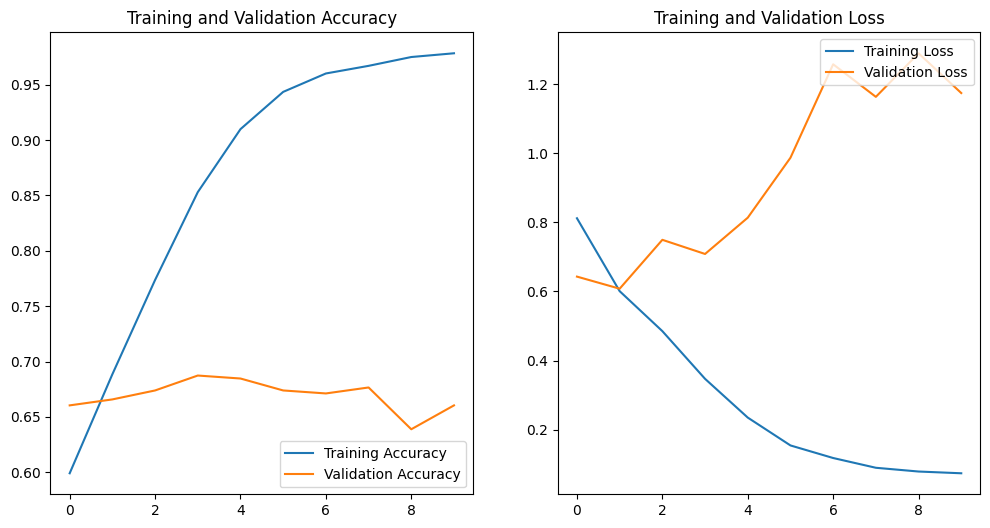

In [ ]:
# Accuracy and Loss Plots
plot_training_history(history_3)


In [ ]:
# Make Predictions
y_pred = model_3.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

12/12 [==============================] - 0s 12ms/step


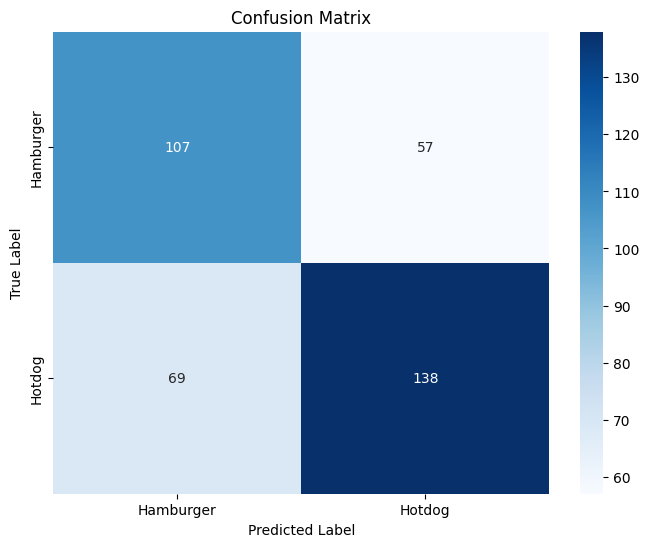

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

### **CNN Model - Iteration #4**

### Early Stopping & Dropout
Early stopping is a method to stop training when the validation metric stops improving, preventing overfitting and saving computational resources.

In [ ]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define a CNN model
model_4 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout layer after pooling
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),   # Dropout layer after first dense layer
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
tf.keras.mixed_precision.set_global_policy("mixed_float16")
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Check if GPU is available
if not tf.config.list_physical_devices('GPU'):
    raise RuntimeError("No GPU device available.")

# Initialize TensorFlow session
tf.keras.backend.clear_session()

# Convert data to TensorFlow tensors
X_train_aug_v2 = tf.convert_to_tensor(X_train_aug)
y_train_aug_v2 = tf.convert_to_tensor(y_train_aug)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Verbosity mode
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)

# Fit the model with early stopping
history_4 = model_4.fit(
    X_train_aug_v2 y_train_aug_v2,
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
232/232 [==============================] - 11s 35ms/step - loss: 1.6734 - accuracy: 0.5822 - val_loss: 0.6336 - val_accuracy: 0.6442
Epoch 2/10
232/232 [==============================] - 7s 29ms/step - loss: 0.6542 - accuracy: 0.6092 - val_loss: 0.6357 - val_accuracy: 0.6442
Epoch 3/10
232/232 [==============================] - 7s 30ms/step - loss: 0.6444 - accuracy: 0.6043 - val_loss: 0.6383 - val_accuracy: 0.6280
Epoch 4/10
232/232 [==============================] - 7s 30ms/step - loss: 0.6194 - accuracy: 0.6188 - val_loss: 0.5993 - val_accuracy: 0.6873
Epoch 5/10
232/232 [==============================] - 7s 29ms/step - loss: 0.5909 - accuracy: 0.6281 - val_loss: 0.6484 - val_accuracy: 0.6226
Epoch 6/10
232/232 [==============================] - 7s 30ms/step - loss: 0.5646 - accuracy: 0.6751 - val_loss: 0.5882 - val_accuracy: 0.6846
Epoch 7/10
232/232 [==============================] - 7s 29ms/step - loss: 0.5214 - accuracy: 0.7196 - val_loss: 0.6166 - val_accuracy: 0.676

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_4, X_test, y_test)

12/12 [==============================] - 0s 9ms/step - loss: 0.5882 - accuracy: 0.6846
Test Loss: 0.5881525278091431
Test Accuracy: 0.684636116027832


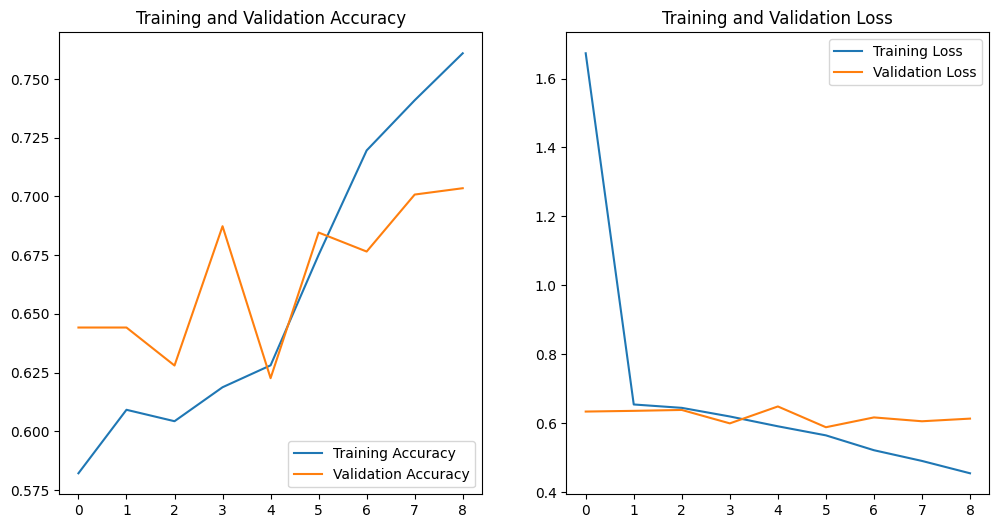

In [ ]:
# Accuracy and Loss Plots
plot_training_history(history_4)

In [ ]:
# Make Predictions
y_pred = model_4.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

12/12 [==============================] - 0s 8ms/step


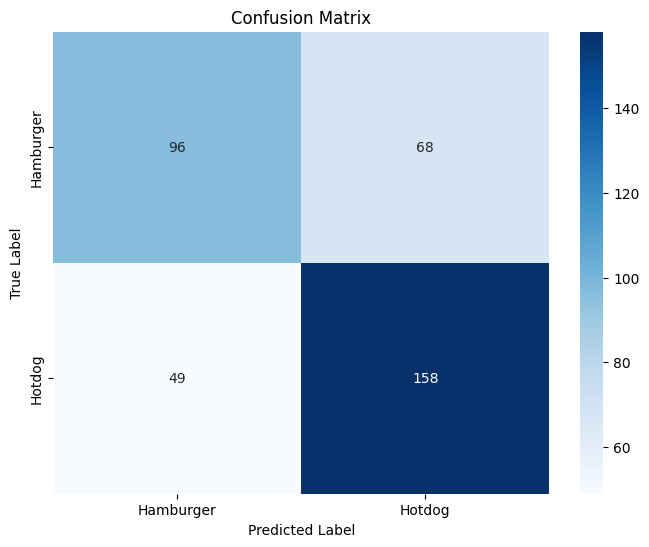

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

### **CNN Model - Iteration #5**

### Additional Layers, Increasing Neurons, Adding Batch Normalization Layers, Early Stopping & Dropout

In [ ]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define a CNN model
model_5 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
# Compile the model
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Verbosity mode
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)

# Fit the model with early stopping
history_5 = model_5.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_5, X_test, y_test)

In [ ]:
# Accuracy and Loss Plots
plot_training_history(history_5)

In [ ]:
# Make Predictions
y_pred = model_5.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

### Model Comparison

In [ ]:
import pandas as pd

# Sample data structure, replace with your actual history data
data = {
    'Model': [],
    'Training Accuracy': [],
    'Validation Accuracy': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Populate the DataFrame
for i in range(1, 6):
    history = eval(f'history_{i}')
    data['Model'].append(f'Model_{i}')
    data['Training Accuracy'].append(history.history['accuracy'][-1])  # Last epoch accuracy
    data['Validation Accuracy'].append(history.history['val_accuracy'][-1])  # Last epoch val_accuracy
    data['Training Loss'].append(history.history['loss'][-1])  # Last epoch loss
    data['Validation Loss'].append(history.history['val_loss'][-1])  # Last epoch val_loss

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df


In [ ]:
# Plot Model Comparison Chart

# Set the aesthetic style of the plots
sns.set_style(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(14, 7))

# Plotting Training and Validation Accuracy
plt.subplot(121)  # 1 row, 2 cols, subplot 1
ax1 = sns.barplot(x='Model', y='Training Accuracy', data=df, color='green', label='Training Accuracy')
ax2 = sns.barplot(x='Model', y='Validation Accuracy', data=df, color='orange', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Add numerical values on the bars for Accuracy
for p in ax1.patches + ax2.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.01, '{:0.2f}'.format(height), ha="center")

# Plotting Training and Validation Loss
plt.subplot(122)  # 1 row, 2 cols, subplot 2
ax3 = sns.barplot(x='Model', y='Validation Loss', data=df, color='orange', label='Validation Loss')
ax4 = sns.barplot(x='Model', y='Training Loss', data=df, color='green', label='Training Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Add numerical values on the bars for Loss
for p in ax3.patches + ax4.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.01, '{:0.2f}'.format(height), ha="center")

plt.show()

## Save the Trained Model

In [ ]:
from pathlib import Path
# Set the model's file path
file_path = Path("/content/Fantastic_4_Project_3/CNN_Model_4.keras")

# Export your model
model_4.save(file_path)

## Loading a Trained Model

In [ ]:
# Load the model to a new object
model_4_imported = tf.keras.models.load_model(file_path)

### Gradio App

In [ ]:
import gradio as gr

def classify_image(image):
    # Resize the image to match the input shape of the model
    image = tf.image.resize(image, (256, 256))
    # Scale image pixels to 0-1
    image = image / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict
    prediction = model_4.predict(image)[0][0]

    # Convert prediction to label
    label = "Hotdog" if prediction > 0.5 else "Hamburger"
    return label

# Adjust Gradio interface accordingly
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(),
    outputs="text",
    title="Hamburger or Hotdog Classifier",
    description="Upload an image to see if it's a hamburger or hotdog."
)

# Launch the interface
iface.launch(share=True)
